----------------------------------

# PART III
# ML regression

Cacharreanding stuff


![alt](https://i.pinimg.com/originals/8c/5c/59/8c5c5923c547867c1615402754d9eb27.gif)
-----------------------------------

*This jupyter is the explanation. The *real thing* is available in the **Cloud Function** folder. 


----------------------------------

I'm going to:

- Normalise the dataset before applying ML. 
- Use **RFE** (Recursive Feature Elimination) to select the best 15 columns to work with, from the 133 I have.
- Use the fastest regression I can. Speed over performance due to Cloud Function requirements.
- Perform cross validation. Unfortunately I have no enough data for train/validation/test
- Once my model is trained, infer data in the whole dataset, to have a dashboard comparing *real keyword* vs *infered keyword*.

Let's have fun :D

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA as pca
from scipy import stats
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [2]:
df=pd.read_csv("input/dataset_final_processed.csv",index_col=[0])

### First attributes selection: Erasing low variance elements

Let's remove the attibutes (columns) which values are quite constant in the whole dataset, so they're not offering much information when everything else is changing.

In [3]:
from sklearn.feature_selection import VarianceThreshold
def variance_threshold_selector(data, threshold):
    '''
    It removes any attribute (column) than vary less than the percentaje of the threshold
    '''
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [4]:
low_v = df.drop(columns=["date","unemployment","outliers_score" ])

In [5]:
X_raw= variance_threshold_selector(low_v, 5) # removing values than vary less than 5%
print("attributes before", low_v.shape,"attributes now", X_raw.shape)

attributes before (87, 118) attributes now (87, 109)


In [6]:
print("removed features: ","\n")
removed=[]
for c in low_v.columns:
    if c not in X_raw.columns:
        #print(c)
        removed.append(c)
removed=pd.DataFrame(removed, columns =["Removed_columns"])

removed.to_csv("./input/removed_features.csv")   #<==========================

removed

removed features:  



,Removed_columns
0,precio_petroleo_1
1,prosperidad_economica_y_finanzas
2,inflacion_economica
3,precio_petroleo_2
4,banco_mundial
5,censura_en_medios
6,subsidios
7,desescalada
8,hacer deporte


### Normalization / Standarization

Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units. Variables that are measured at different scales do not contribute equally to the analysis and might end up creating a bais.

In other hand, Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data

In [7]:
# Normalizacion with sklearn
# remove dates and target
#X_raw = df.drop(columns=["date","unemployment","outliers_score" ]) #already removed in low_v

normalizer = preprocessing.MinMaxScaler()
X = pd.DataFrame(normalizer.fit_transform(X_raw))

#standardizer = preprocessing.StandardScaler()
#X = pd.DataFrame(standardizer.fit_transform(X_raw))

X.columns= X_raw.columns
X.shape
target=df["unemployment"]
print("X shape: ", X.shape, ", target shape: ", target.shape)
X.head(2)

X shape:  (87, 109) , target shape:  (87,)


,vigilancia,inestabilidad_politica,rebelion,terrorismo,protestas,corrupcion_1,refugiados_1,ejercito,seguridad_nacional,extremismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,0.640186,0.894425,0.579915,0.438318,0.995760,0.705565,0.780032,0.893647,0.420146,0.664755,...,0.43,0.01,0.57,0.27,0.12,0.052632,0.166667,0.34,0.870370,0.142857
1,0.231892,0.778049,0.654679,0.928255,0.835291,0.398453,0.701877,0.823433,0.765143,0.929841,...,0.50,0.01,0.45,0.39,0.09,0.105263,0.083333,0.27,0.814815,0.114286


# RFE

In [8]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [10]:
# Minimal number of features to play with
min_number_features =  df.shape[0]//10

In [11]:
regression = Lasso(alpha=0.1)
#regression = LinearRegression()
rfecv = RFECV(estimator=regression,
              step=1, 
              min_features_to_select=min_number_features, 
              cv=KFold(n_splits=10,
                    shuffle=True,
                    random_state=42),
              scoring='neg_mean_squared_error')
rfecv.fit(X_train, target_train)
print(rfecv.score(X_train, target_train))

0.7734970213482977


In [12]:
regression.fit(X_train,target_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [13]:
print(regression.coef_)

[ -0.          -0.          -3.36990542   0.          -0.
   0.          -0.          -0.88615216  -0.           4.18560988
  -0.          -0.           4.08357863  -0.           0.
  -1.30237275  -2.94459852   0.33130813   0.          -0.
  -2.24168358   0.          -1.39812096  -0.           6.74302247
  -0.          -0.           0.79702672  -7.9692335    4.62850961
 -11.25232488  -0.          -0.           0.          -3.51686065
  -5.56293782  -0.19119318   0.          60.47147549  -0.
  -0.           0.          -2.33182366  -2.50868823  -0.
  -0.          -0.          33.60483302   0.          -0.
   5.96146444  -5.14193024  -0.          -0.          -6.19744883
   9.86930825   0.           0.          -0.           0.
  -0.          -7.459236     0.          -0.          -0.
  -0.          -0.          -0.           0.           0.
   0.          -0.           0.          -0.           0.
  -0.          -0.          -0.          -0.           0.
   0.          -3.62779074   0. 

In [14]:
len(regression.coef_)

109

In [15]:
regression.intercept_

1.2067881699215128

In [16]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 24


In [17]:
import datetime

In [18]:
number_features=pd.DataFrame()
number_features["number_columns"]=pd.Series(rfecv.n_features_)
number_features["date"]= pd.to_datetime(datetime.datetime.now())
number_features.to_csv("./input/number_features.csv") # <=====================

number_features

,number_columns,date
0,24,2021-01-02 22:12:54.160398


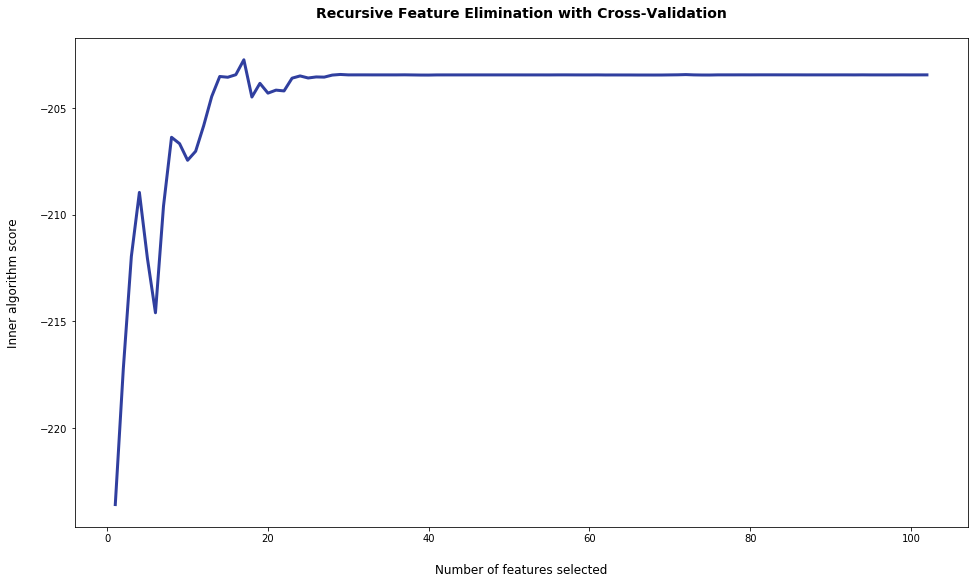

In [19]:
from matplotlib import pyplot
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=12, labelpad=20)
plt.ylabel('Inner algorithm score', fontsize=12, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.savefig("./input/RFE_columns.jpg")   # <====================

plt.show()

In [20]:
ranking_features=pd.DataFrame()
ranking_features["features"]=X_train.columns
ranking_features["ranking"]=rfecv.ranking_
ranking_features.sort_values(by="ranking", ascending=True, inplace=True, ignore_index=True)
ranking_features.head(40)

,features,ranking
0,deshaucio,1
1,inmigracion_1,1
2,racismo,1
3,badi,1
4,banco alimentos,1
5,bullying,1
6,coronavirus,1
7,cruz roja,1
8,tinder,1
9,disney,1


In [21]:
# This is quite a wierd of feature selection
X_train.drop(X_train.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

/home/vargas/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[  0   1   3   4   5   6   7   8  10  11  13  14  15  17  18  19  20  21
  22  23  25  26  27  31  32  33  36  37  39  40  41  42  43  44  45  46
  48  49  52  53  56  57  58  59  60  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  82  83  84  85  86  87  88  89
  90  91  92  97  98  99 102 103 104 105 106 107 108]


In [23]:
X_train.head(2)

,rebelion,extremismo,macroeconomia_deuda_y_vulnerabilidad,stock_market,energias_renovables,emergencia_sanitaria,inmigracion_1,racismo,badi,banco alimentos,...,deshaucio,disney,erc,nacionalismo,refugiados_2,remoto,residencia ancianos,sepe,teletrabajo,tinder
0,0.579915,0.664755,0.452098,0.621209,0.751241,0.730839,0.763941,0.871963,0.46,0.03,...,1.00,0.535714,0.09,0.22,0.39,0.542373,0.56,0.164179,0.01,0.57
1,0.654679,0.929841,0.884148,0.701700,0.751241,0.904227,0.786898,0.871963,0.57,0.02,...,0.58,0.500000,0.06,0.31,0.61,0.525424,0.54,0.164179,0.01,0.45


# Next step... ?

In [24]:
target_train.shape

(83,)

In [25]:
X_train.shape

(83, 24)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [27]:
x_train, x_test,y_train,y_test =train_test_split(X_train,target_train)

In [28]:
linreg=LinearRegression()
linreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
print(linreg.intercept_, linreg.coef_)

-55.38713568060085 [ -7.97757117  10.5211428    9.39702906  -2.74163126  33.35713005
  -9.84994864   8.43773588  14.71323322  -9.16855347 -10.45590435
  72.06300091  55.04493769   9.15702249   4.74889886  -3.67122045
  24.07875494 -12.4155225   -3.57782838  22.04824105 -24.30680303
  -0.62234329  35.59656153 -31.69483851   9.85866859]


In [30]:
zip(X_train.columns, linreg.coef_)

In [31]:
y_pred=linreg.predict(x_test)

In [32]:
from sklearn import metrics

In [33]:
print(metrics.mean_absolute_error(y_test,y_pred))

7.091156879211943


In [34]:
print(metrics.mean_squared_error(y_test,y_pred))

113.31149250160152


In [35]:
print(np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

10.644787104569144


In [36]:
# Métricas de evaluación.
metricas = {
  'MAE': 'neg_mean_absolute_error',
    "r2": "r2",
  'RMSE': make_scorer(
          lambda y, y_pred:
            sqrt(mean_squared_error(y, y_pred)),
            greater_is_better=False),
  'MAPE': make_scorer(
          lambda y, y_pred:
            np.mean(np.abs((y - y_pred) / y)) * 100,
            greater_is_better=False)}

NameError: name 'make_scorer' is not defined

In [ ]:
models= {"linear reg":LinearRegression(),
         "lasso 0.1": Lasso(alpha=0.1), #alpha=1 == linear regression
         "lasso 0.5": Lasso(alpha=0.5),
         "decission tree random": DecisionTreeRegressor(random_state=42, splitter="random"),
         "decission tree best": DecisionTreeRegressor(random_state=42, splitter="best"),
        }

In [ ]:
# Validación y evaluación del modelo.
reg=LinearRegression()
evaluacion = cross_validate(reg, X_train, target_train,
                cv = KFold(n_splits=10), scoring = metricas)

In [ ]:
#pprint(evaluacion)
for e in evaluacion:
    print(e, evaluacion.get(e).mean(), evaluacion.get(e).std())

In [ ]:
jññlkjñzjñlkjñlkj